Starting parameter sweep over SARIMA parameters...
Tested order: (0, 0, 0), seasonal_order: (0, 0, 0, 12), AIC: 1771.58
Tested order: (0, 0, 0), seasonal_order: (0, 0, 1, 12), AIC: 1464.08
Tested order: (0, 0, 0), seasonal_order: (0, 0, 2, 12), AIC: 1222.83
Tested order: (0, 0, 0), seasonal_order: (0, 1, 0, 12), AIC: 797.04
Tested order: (0, 0, 0), seasonal_order: (0, 1, 1, 12), AIC: 705.46
Tested order: (0, 0, 0), seasonal_order: (0, 1, 2, 12), AIC: 634.91
Tested order: (0, 0, 0), seasonal_order: (0, 2, 0, 12), AIC: 729.82
Tested order: (0, 0, 0), seasonal_order: (0, 2, 1, 12), AIC: 661.49
Tested order: (0, 0, 0), seasonal_order: (0, 2, 2, 12), AIC: 607.04
Tested order: (0, 0, 0), seasonal_order: (1, 0, 0, 12), AIC: 740.35
Tested order: (0, 0, 0), seasonal_order: (1, 0, 1, 12), AIC: 724.30
Tested order: (0, 0, 0), seasonal_order: (1, 0, 2, 12), AIC: 659.53
Tested order: (0, 0, 0), seasonal_order: (1, 1, 0, 12), AIC: 684.60
Tested order: (0, 0, 0), seasonal_order: (1, 1, 1, 12), AIC: 6

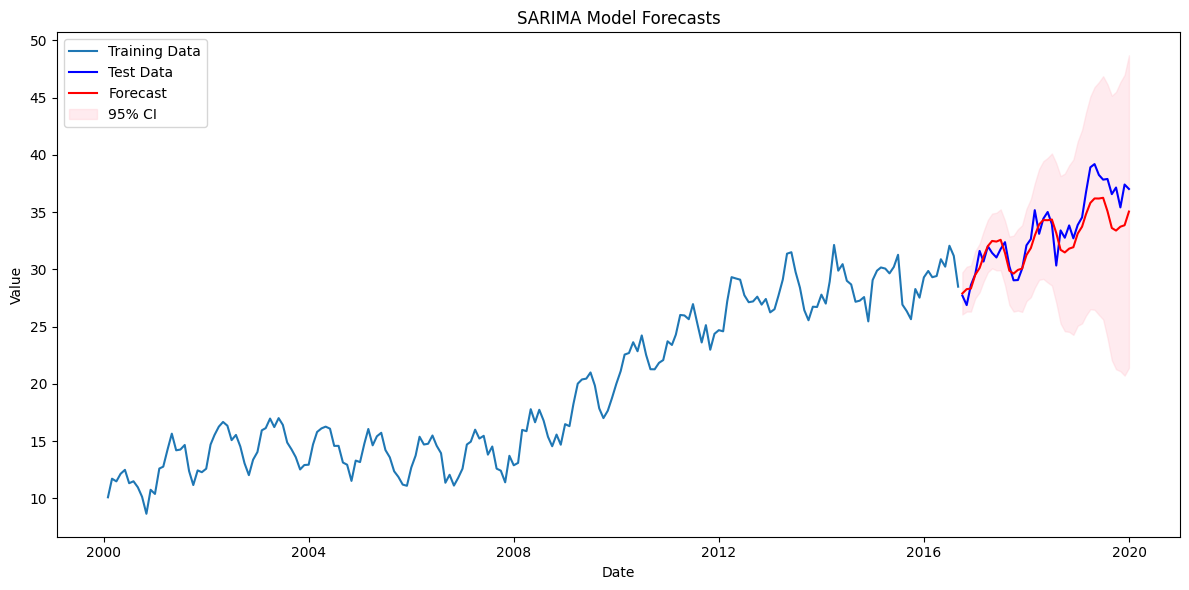

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

def generate_synthetic_data(n_periods=240):
    # dates don't matter here since it's synthetic data
    dates = pd.date_range(start='2000-01-01', periods=n_periods, freq='M')

    t = np.arange(n_periods)
    # a complex moving trend
    trend = 0.05 * t + 0.0003 * t**2 + 3 * np.sin(2 * np.pi * t / 120)

    # add a seasonal trend
    seasonality = 2 * np.sin(2 * np.pi * t / 12)

    # increasing std dev over time (more noise)
    noise_scale = 0.5 + np.random.uniform(0.002, 0.007) * t
    noise = np.random.normal(loc=0, scale=noise_scale)

    # add constant (10) for baseline
    data = 10 + trend + seasonality + noise

    return pd.Series(data, index=dates)

def parameter_sweep(train, seasonal_period=12):
    # p, d, q ranges for non-seasonal and seasonal parameter sweeps
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in pdq]

    best_aic = np.inf
    best_order = None
    best_seasonal = None
    best_model = None

    print("Starting parameter sweep over SARIMA parameters...")
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = SARIMAX(train,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    best_seasonal = seasonal_order
                    best_model = results
                print(f"Tested order: {order}, seasonal_order: {seasonal_order}, AIC: {results.aic:.2f}")
            except Exception as e:
                continue

    print("\nBest model found:")
    print(f"Order: {best_order}, Seasonal Order: {best_seasonal}, AIC: {best_aic:.2f}\n")
    return best_order, best_seasonal, best_model

def plot_forecasts(train, test, forecast, conf_int):
    plt.figure(figsize=(12, 6))

    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Test Data', color='blue')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')

    plt.fill_between(conf_int.index,
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     color='pink', alpha=0.3, label='95% CI')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('SARIMA Model Forecasts')
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    series = generate_synthetic_data(n_periods=240)

    # using last 40 observations as test set
    train, test = series.iloc[:-40], series.iloc[-40:]

    # param sweep for best AIC
    best_order, best_seasonal, best_model = parameter_sweep(train, seasonal_period=12)

    # one step ahead forecasts
    pred = best_model.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    pred_mean = pred.predicted_mean
    pred_conf_int = pred.conf_int(alpha=0.05)

    plot_forecasts(train, test, pred_mean, pred_conf_int)

if __name__ == '__main__':
    main()
